In [307]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn

from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, SGDClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, accuracy_score, roc_curve, auc, RocCurveDisplay

from matplotlib.patches import Patch
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (
    cross_val_predict,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from imblearn.over_sampling import SMOTE

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [308]:
def isMyModelGood(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot()

    r2 = r2_score(y_test, y_pred)
    print("r^2:", r2)
    mse = mean_squared_error(y_test, y_pred)
    print("MSE test:", mse)

    accuracy = accuracy_score(y_test, y_pred)

    precision = precision_score(y_test, y_pred)

    recall = recall_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    print(f"Model : Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    print('AUC = ',auc(fpr, tpr) )


In [309]:
#Pipeline
df = pd.read_csv('startup_data.csv')
# df.info()

In [310]:
#dropping cols, encoding

cols_to_drop = ['Unnamed: 0', 'Unnamed: 6', 'object_id', 'id', 'state_code.1', 'state_code', 'city', 'latitude', 'longitude', 'zip_code', 'name', 'category_code', 'closed_at', 'labels']
df2 = df.drop(columns=cols_to_drop, errors="ignore")

target = df2.columns[-1]
df2[target] = df2[target].map({'closed': 0, 'acquired': 1})

object_cols = df2.select_dtypes(include=["object"]).columns[:3]

for col in object_cols:
    df2[col] = pd.to_datetime(df2[col], errors="coerce") 
    df2[col] = df2[col].view("int64")



impute_cols = ['age_first_milestone_year', 'age_last_milestone_year']
#will be applying scaler to all features except for categorical features

#df2 = pd.get_dummies(df2, columns=['status'], drop_first=True)
df2.info()
#encoding status

# print("cols in df2:", df2.columns.tolist())
# print("impute columns:", impute_cols)
# print("scale columns:", scale_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                923 non-null    int64  
 1   first_funding_at          923 non-null    int64  
 2   last_funding_at           923 non-null    int64  
 3   age_first_funding_year    923 non-null    float64
 4   age_last_funding_year     923 non-null    float64
 5   age_first_milestone_year  771 non-null    float64
 6   age_last_milestone_year   771 non-null    float64
 7   relationships             923 non-null    int64  
 8   funding_rounds            923 non-null    int64  
 9   funding_total_usd         923 non-null    int64  
 10  milestones                923 non-null    int64  
 11  is_CA                     923 non-null    int64  
 12  is_NY                     923 non-null    int64  
 13  is_MA                     923 non-null    int64  
 14  is_TX     

In [311]:
#splitting data

x = df2.iloc[:,0:34]
y = df2['status']

x.info()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=27)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=27)

x_train = x_train.astype(float)
x_test = x_test.astype(float)
x_val = x_val.astype(float)

y_train = y_train.astype(float)
y_test = y_test.astype(float)
y_val = y_val.astype(float)

print("class dist.", Counter(y_train))

x_train.info()

#after running mi and moving around the steps, found a bunch of issues with data leakage
#apparently i needed to split before preprocessing, and i was preprocessing the entire data set instead of just the training data which led to huge data leakage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                923 non-null    int64  
 1   first_funding_at          923 non-null    int64  
 2   last_funding_at           923 non-null    int64  
 3   age_first_funding_year    923 non-null    float64
 4   age_last_funding_year     923 non-null    float64
 5   age_first_milestone_year  771 non-null    float64
 6   age_last_milestone_year   771 non-null    float64
 7   relationships             923 non-null    int64  
 8   funding_rounds            923 non-null    int64  
 9   funding_total_usd         923 non-null    int64  
 10  milestones                923 non-null    int64  
 11  is_CA                     923 non-null    int64  
 12  is_NY                     923 non-null    int64  
 13  is_MA                     923 non-null    int64  
 14  is_TX     

In [312]:

impute_cols = [col for col in impute_cols if col in x_train.columns]

imputer = SimpleImputer(strategy='median')

x_train[impute_cols] = imputer.fit_transform(x_train[impute_cols])
x_val[impute_cols] = imputer.transform(x_val[impute_cols])
x_test[impute_cols] = imputer.transform(x_test[impute_cols])

x_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 590 entries, 24 to 129
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                590 non-null    float64
 1   first_funding_at          590 non-null    float64
 2   last_funding_at           590 non-null    float64
 3   age_first_funding_year    590 non-null    float64
 4   age_last_funding_year     590 non-null    float64
 5   age_first_milestone_year  590 non-null    float64
 6   age_last_milestone_year   590 non-null    float64
 7   relationships             590 non-null    float64
 8   funding_rounds            590 non-null    float64
 9   funding_total_usd         590 non-null    float64
 10  milestones                590 non-null    float64
 11  is_CA                     590 non-null    float64
 12  is_NY                     590 non-null    float64
 13  is_MA                     590 non-null    float64
 14  is_TX         

In [313]:
# Initialize a list to track removed features
x_with_const = add_constant(x_train) 
removed_features = []

# Set your VIF threshold
threshold = 10

while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = x_train.columns
    vif_data["VIF"] = [
        variance_inflation_factor(x_with_const, i + 1) for i in range(x_train.shape[1])
    ]

    # Find the feature with the highest VIF above the threshold
    max_vif = vif_data["VIF"].max()
    if max_vif > threshold:
        feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
        print(f"Removing '{feature_to_remove}' with VIF: {max_vif:.2f}")
        x_train = x_train.drop(columns=[feature_to_remove], errors='ignore')
        x_with_const = add_constant(x_train)  # Recalculate constant after dropping
        removed_features.append(feature_to_remove)
    else:
        break  # Stop if no features exceed the threshold

# Remove the same features from x_test and x_val
x_test = x_test.drop(columns=removed_features, errors='ignore')
x_val = x_val.drop(columns=removed_features, errors='ignore')

print("Removed features:", removed_features)

Removing 'age_last_funding_year' with VIF: 11522047410.82
Removing 'age_first_funding_year' with VIF: 8672200809.66
Removed features: ['age_last_funding_year', 'age_first_funding_year']


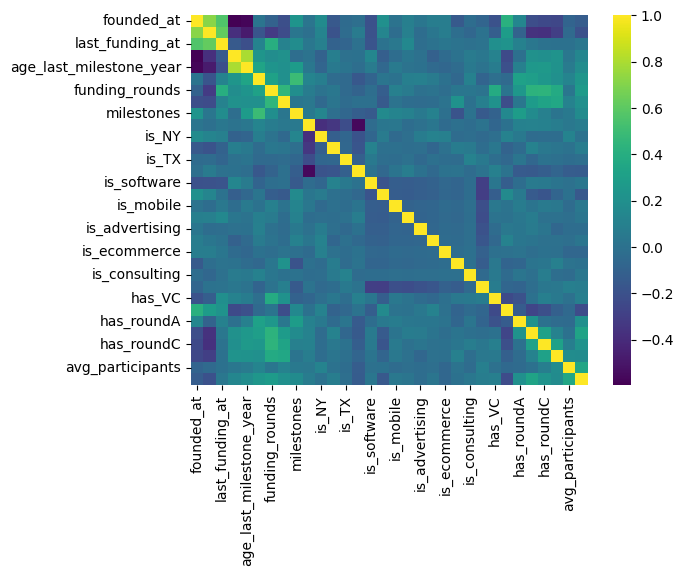

<class 'pandas.core.frame.DataFrame'>
Index: 590 entries, 24 to 129
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                590 non-null    float64
 1   first_funding_at          590 non-null    float64
 2   last_funding_at           590 non-null    float64
 3   age_first_milestone_year  590 non-null    float64
 4   age_last_milestone_year   590 non-null    float64
 5   relationships             590 non-null    float64
 6   funding_rounds            590 non-null    float64
 7   funding_total_usd         590 non-null    float64
 8   milestones                590 non-null    float64
 9   is_CA                     590 non-null    float64
 10  is_NY                     590 non-null    float64
 11  is_MA                     590 non-null    float64
 12  is_TX                     590 non-null    float64
 13  is_otherstate             590 non-null    float64
 14  is_software   

In [314]:


#dropping columns with a high corr
threshold = .8
corr_matrix = x_train.corr()
sns.heatmap(corr_matrix, annot=False, cmap="viridis")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [
    column for column in upper.columns if any(upper[column] > threshold)
]

x_train = x_train.drop(columns=high_corr_features, errors='ignore')
x_test = x_test.drop(columns=high_corr_features, errors='ignore')
x_val = x_val.drop(columns=high_corr_features, errors='ignore')

x_train.info()

print(high_corr_features)

In [315]:
#mi to deal with multicolinearity on things like is_ma, is_ny, is_ca, etc
mi = mutual_info_classif(x_train, y_train)
mi_scores = pd.Series(mi, index=x_train.columns).sort_values(ascending=False)
print(mi_scores)
top_features = mi_scores[mi_scores >0.01].index

x_train = x_train[top_features]
x_test = x_test[top_features]
x_val = x_val[top_features]

# class_distribution = Counter(y_test)
# print("Class distribution in y_test:", class_distribution)


# print(x_train.head())

# most models did worse with mi, not sure why but i think its better to keep mi
# commented it out mi and tried again, results were still worse than before mi
# i think its how i moved the data organization and pipeline

relationships               0.135158
age_last_milestone_year     0.110446
founded_at                  0.098447
age_first_milestone_year    0.079194
avg_participants            0.059324
milestones                  0.057561
has_roundA                  0.053617
funding_total_usd           0.048524
funding_rounds              0.038908
is_othercategory            0.038549
has_roundC                  0.037562
first_funding_at            0.028914
is_NY                       0.028014
is_top500                   0.026359
has_angel                   0.026222
is_otherstate               0.026051
last_funding_at             0.016076
is_ecommerce                0.010628
is_biotech                  0.008187
is_TX                       0.007955
has_roundB                  0.001938
is_MA                       0.000330
is_CA                       0.000000
is_software                 0.000000
is_web                      0.000000
is_consulting               0.000000
is_advertising              0.000000
i

In [316]:
#SMOTE to oversample minority class since imbalance is screwing with pred
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

print("class dist. after SMOTE: ", Counter(y_train))

class dist. after SMOTE:  Counter({0.0: 378, 1.0: 378})


In [317]:
x_train.info()
scale_cols = [col for col in x_train.columns[0:8]]+['first_funding_at', 'last_funding_at']
scaler = StandardScaler()
x_train[scale_cols] = scaler.fit_transform(x_train[scale_cols])
x_test[scale_cols] = scaler.transform(x_test[scale_cols])
x_val[scale_cols] = scaler.transform(x_val[scale_cols])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   relationships             756 non-null    float64
 1   age_last_milestone_year   756 non-null    float64
 2   founded_at                756 non-null    float64
 3   age_first_milestone_year  756 non-null    float64
 4   avg_participants          756 non-null    float64
 5   milestones                756 non-null    float64
 6   has_roundA                756 non-null    float64
 7   funding_total_usd         756 non-null    float64
 8   funding_rounds            756 non-null    float64
 9   is_othercategory          756 non-null    float64
 10  has_roundC                756 non-null    float64
 11  first_funding_at          756 non-null    float64
 12  is_NY                     756 non-null    float64
 13  is_top500                 756 non-null    float64
 14  has_angel 

In [318]:
print(x_val.isnull().sum())  # Check for NaN counts in each column
print(x_val.isnull().any())  # Check if any column contains NaN

relationships               0
age_last_milestone_year     0
founded_at                  0
age_first_milestone_year    0
avg_participants            0
milestones                  0
has_roundA                  0
funding_total_usd           0
funding_rounds              0
is_othercategory            0
has_roundC                  0
first_funding_at            0
is_NY                       0
is_top500                   0
has_angel                   0
is_otherstate               0
last_funding_at             0
is_ecommerce                0
dtype: int64
relationships               False
age_last_milestone_year     False
founded_at                  False
age_first_milestone_year    False
avg_participants            False
milestones                  False
has_roundA                  False
funding_total_usd           False
funding_rounds              False
is_othercategory            False
has_roundC                  False
first_funding_at            False
is_NY                       False
is_to

AUC =  0.6607385283736085


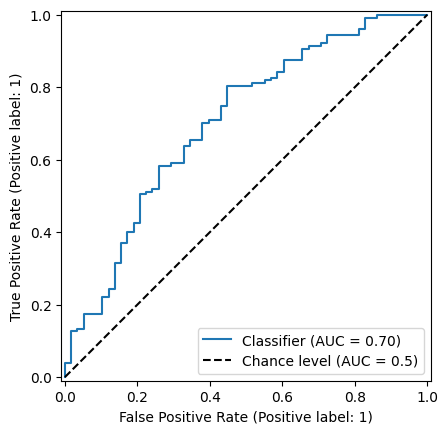

In [319]:
clf = LogisticRegression(random_state=42)
clf.fit(x_train, y_train)
#print("model score: %.3f" % clf.score(x_val, y_val))  # average accuracy

y_pred=clf.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print('AUC = ',auc(fpr, tpr) )
prob=clf.predict_proba(x_test)[:,1]
RocCurveDisplay.from_predictions(y_test, prob,plot_chance_level=True)
plt.show()




r^2: -0.5069237035025795
MSE test: 0.32432432432432434
Model : Accuracy=0.676, Precision=0.802, Recall=0.701, F1=0.748
AUC =  0.6607385283736085
r^2 train: -0.031746031746031855
MSE train: 0.25793650793650796


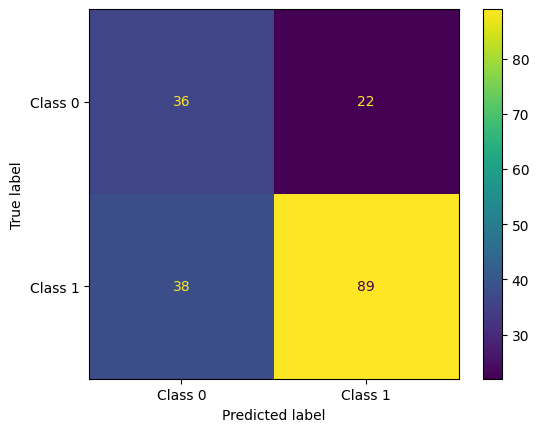

In [320]:
isMyModelGood(y_test, y_pred)
y_train_pred = clf.predict(x_train)

r22 = r2_score(y_train, y_train_pred)
print("r^2 train:", r22)
#both r2 worse than baseline


mse2 = mean_squared_error(y_train, y_train_pred)
print("MSE train:", mse2)
#mse test also worse than baseline, but not by as much like with r2

#gonna test this with more models n see now

In [321]:
y_baseline = [y_train.mean()] * len(y_test)

# MSE for the baseline
baseline_mse = mean_squared_error(y_test, y_baseline)
print("Baseline MSE:", baseline_mse)

Baseline MSE: 0.25


In [322]:
#perceptron-adaline
class Adaline:
    def __init__(self, lr=0.01, n_epoch=150):
        self.lr = lr
        self.n_epoch = n_epoch
        self.weight = None
        self.bias = None
    
    #computing weighted sum of inputs and adding bias
    def __func__(self, x):
        return np.dot(x, self.weight) + self.bias
    
    #updating weight and biases for each epoch and gets predictions
    #in each epoch computes output, finds error, computes gradient of loss (mse) and updates weights and biases
    def fit(self, x, y):
        self.weight=np.zeros(x.shape[1])
        self.bias=0

        for _ in range(self.n_epoch):
            output=self.__func__(x)
            error = output-y
            dw = 2*np.dot(error, x)/x.shape[0]
            db = 2*error.mean()

            self.weight = self.weight-self.lr*dw
            self.bias-=self.lr*db
    
    #now we use the model
    def predict(self, x):
        return np.where(self.__func__(x)>=.5, 1,0)


r^2: -0.6073852837360849
MSE test: 0.34594594594594597
Model : Accuracy=0.654, Precision=0.832, Recall=0.622, F1=0.712
AUC =  0.6730925875644855


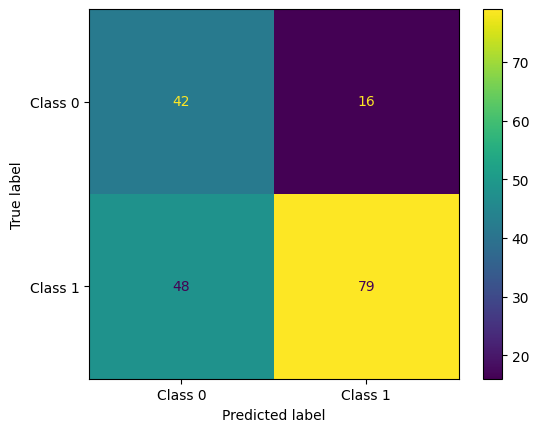

In [323]:
ada = Adaline()
ada.fit(x_train, y_train)

y_pred=ada.predict(x_test)

isMyModelGood(y_test, y_pred)
#this is even worse than logistic regresion broooooooo
#also the r2 and mse are exactly the same however the cm is different so idk if this is just a coincidence
#these are both linear models, which might be too simple, the data doesnt look linearly separable, which means linear models wont work well here

#okay actually disregard the above comments i was stupid and forget to pipeline the data before running the model
#its actually somewhat better than LR, but still lacking.
#small improvements are improvements

In [324]:
#custom logistic regression
#cuz the first time was mainly for testing my model

def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogRegSimple():
    def __init__(self, lr=0.1, n_epoch=100):
        self.lr=lr
        self.n_epoch = n_epoch
        self.weights = None
        self.bias = None

    #forward calculates logits (raw score for the sigmoid function)
    #forward = forward pass (duh)
    def forward(self, x):
        return sigmoid(np.dot(x, self.weights)+self.bias)
    
    # fit initializes weights and biases, then for each epoch it makes a prediction and calculates loss, then calculates bias and weights
    def fit(self, x, y):
        self.weights=np.zeros(x.shape[1])
        #had to change from self.weights = np.array([0, 0]) since this doesnt update according to x passed
        self.bias=0

        for epoch in range(self.n_epoch):
            y_pred = self.forward(x)
            loss = (np.dot(-y, np.log(y_pred))-np.dot(1-y, np.log(1-y_pred)))/x.shape[0]

            #note to self --> these are the gradient updates
            self.weights = self.weights+self.lr*np.dot(x.T, y-y_pred)/x.shape[0]
            self.bias+=self.lr*(y-y_pred).mean()

        return self
    
    def predict(self, x):
        return self.forward(x).round()
    def param(self):
        return self.weights, self.bias

r^2: -0.6325006787944611
MSE test: 0.35135135135135137
Model : Accuracy=0.649, Precision=0.782, Recall=0.677, F1=0.726
AUC =  0.6316861254412165


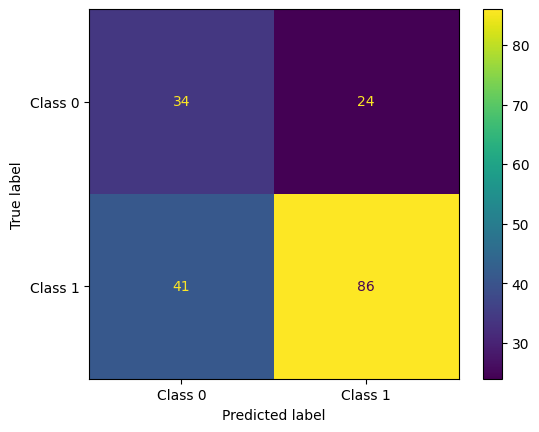

In [325]:

logreg = LogRegSimple(lr=0.1,n_epoch=200)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)


isMyModelGood(y_test, y_pred)

#better in some aspects, worse in others, but better than the library included logreg, prob because of the params i passed
#r2 and mse still trash tho

In [326]:
#svm

class SVM:
    def __init__(self, lr = .01, lambda_param=0.01, n_epoch = 1000):
        self.lr = lr
        self.lambda_param=lambda_param
        self.n_epoch=n_epoch
        self.weights=None
        self.bias=None

    #just in general, fit optimizes weights and bias of models
    #here it uses a hinge loss function w gradient descent
    def fit(self, x, y):
        n_samples, n_features = x.shape

        #just recodes labels, turning -1 to 1
        yc = np.where(y <=0, -1, 1)

        self.weights = np.zeros(n_features)
        self.bias=0

        #training loop
        for _ in range(self.n_epoch):
            #updates weights and bias for each training sample
            for idx, x_i in enumerate(x):
                condition = yc[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    #here, if the sample is classified correctly 0 loss
                    self.weights -= self.lr*(2*self.lambda_param*self.weights)
                else:
                    #otherwise hinge loss gradient will be applied (and regularization term)
                    self.weights -= self.lr*(2*self.lambda_param*self.weights-np.dot(x_i, yc[idx]))
                    self.bias-=self.lr*yc[idx]
    
    def predict(self, x):
        approx = np.dot(x, self.weights) - self.bias
        #return np.sign(approx)
        #needs to be removed since getting 3 labels, need to be binary for metrics
        return np.where(approx >=0, 1, 0)

In [328]:
# svm = SVM(lr=.01, lambda_param=.01, n_epoch=1000)
# svm.fit(x_train, y_train)
# y_pred = svm.predict(x_test)

# isMyModelGood(y_test, y_pred)

#worse than the other two, prob because its also a linear model

r^2: -0.4315775183274506
MSE test: 0.3081081081081081
Model : Accuracy=0.692, Precision=0.778, Recall=0.772, F1=0.775
AUC =  0.6444474613087157


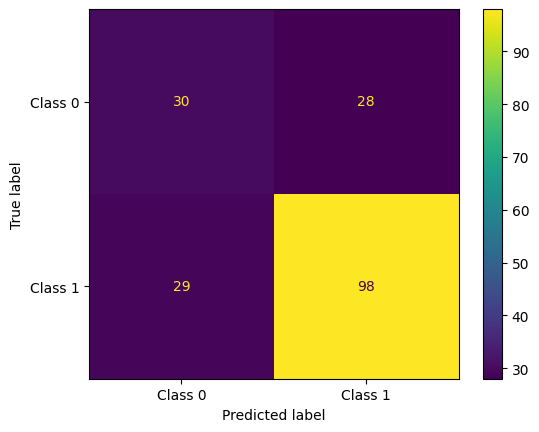

In [329]:
#decision tree
tree = DecisionTreeClassifier(criterion='entropy')

tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)

isMyModelGood(y_test, y_pred)

#not great but rf should improve on this at least

r^2: -0.1804235677436874
MSE test: 0.25405405405405407
Model : Accuracy=0.746, Precision=0.803, Recall=0.835, F1=0.819
AUC =  0.6931849036111866


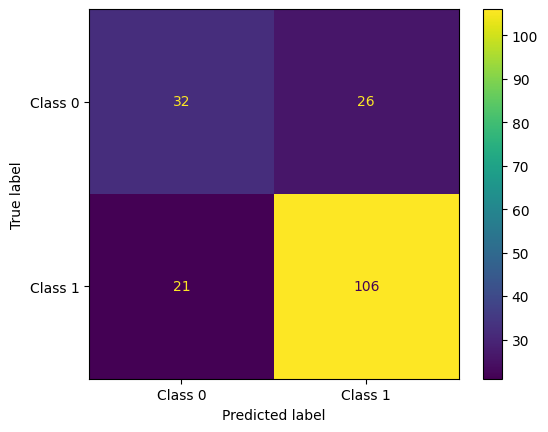

In [333]:
#rf
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=27, class_weight='balanced')
#here i didnt need to use pipeline since rf doesnt compare features against each other but its here for consistencey
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

isMyModelGood(y_test, y_pred)

#a lot better than the others
#r2 is finally positive, and mse is lower, metrics are also higher across the board


In [334]:
#cross validation

sss = StratifiedShuffleSplit(n_splits = 5, test_size = .2, random_state=42)
#originally ran this without sss, got more variable results, this def helped

scores=cross_val_score(rf, x_train, y_train, cv=sss)
print(scores)
#wow, that actually varies a lot
print("%0.2f acc with sd of %0.2f" %(scores.mean(), scores.std()))
#was originally gonna skip over the cv but not after seeing how much is varies

fscores=cross_val_score(rf, x_train, y_train, cv=sss,scoring='f1_macro')
print("%0.2f f1-score with a standard deviation of %0.2f" % (fscores.mean(), fscores.std()))

[0.82236842 0.76315789 0.79605263 0.73026316 0.75      ]
0.77 acc with sd of 0.03
0.77 f1-score with a standard deviation of 0.03


r^2: -0.1804235677436874
MSE test: 0.25405405405405407
Model : Accuracy=0.746, Precision=0.803, Recall=0.835, F1=0.819
AUC =  0.6931849036111866


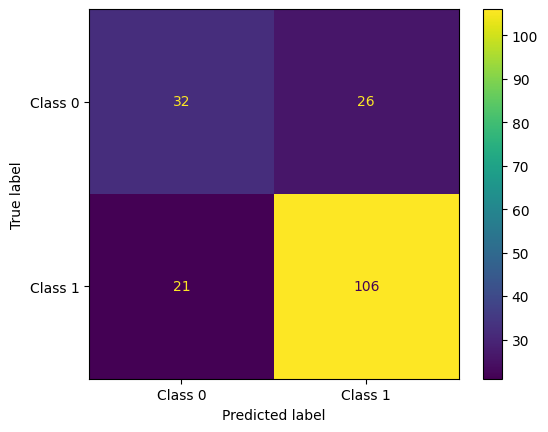

In [335]:
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

isMyModelGood(y_test, y_pred)

